In [ ]:
# default_exp hists

# fullstream.hists

> Module for creating histograms based off of the output of neural net classifiers.

In [ ]:
# export
import pyhf

pyhf.set_backend(pyhf.tensor.jax_backend())

import jax

In [ ]:
# export
def hists_from_nn(nn, params, sig, bkg, scale=True, scale_factors=[0.02, 0.1]):
    """Create nn-based binned summary statistics from signal and background events. 
    nn should be the 'predict', 'fit' etc. method that's callable on arguments (nn_params,data). Assumes logsoftmax output.
    """

    # set some arbitrary scale factors
    # todo change
    sig_sf = scale_factors[0] if scale else 1
    bkg_sf = scale_factors[1] if scale else 1

    sighist = jax.numpy.sum(jax.numpy.exp(nn(params, sig)), axis=0) * sig_sf
    bkghist = jax.numpy.sum(jax.numpy.exp(nn(params, bkg)), axis=0) * bkg_sf

    return sighist, bkghist

/home/phinate/envs/fullstream/lib/python3.7/site-packages/jax-0.1.58-py3.7.egg/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.



Starting training...
Epoch 0 in 3.17 sec
Training set accuracy 0.87475


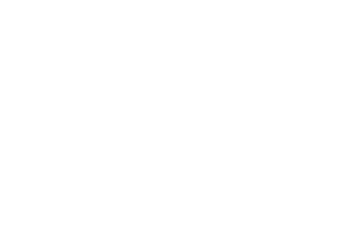

In [ ]:
from fullstream.nn import simple_classifier

x = simple_classifier(dist=3)
_ = x.train(num_epochs=1)
nn_params = x.params

In [ ]:
from fullstream.data import get_three_blobs

sig, bkg, _ = get_three_blobs(num_points=1000)
sighist, bkghist = hists_from_nn(x.predict, nn_params, sig, bkg)

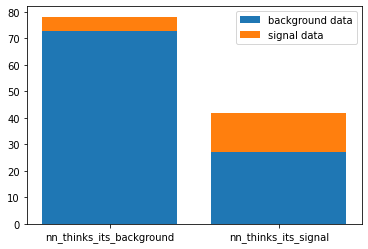

In [ ]:
import matplotlib.pyplot as plt

plt.bar(
    ["nn_thinks_its_background", "nn_thinks_its_signal"],
    bkghist,
    label="background data",
)
plt.bar(
    ["nn_thinks_its_background", "nn_thinks_its_signal"],
    sighist,
    bottom=bkghist,
    label="signal data",
)
plt.legend()

In [ ]:
# export
def hists_from_nn_bkg_var(
    nn, params, sig, bkg, scale=True, use_jax=True, scale_factors=[0.02, 0.1]
):
    """Create nn-based binned summary statistics from signal and background events, with the background histograms containing multiple variations.
    The std of these variations is then the uncertainty.
    
    nn should be the 'predict', 'fit' etc. method that's callable on arguments (nn_params,data). Assumes logsoftmax output.
    
    bkg: array-like, containing len(bkg) modes of the background.
    --> bkg_hist = mean()
    
    """

    assert (
        len(bkg.shape) == 3
    ), f"Shape error: bkg is of dim {len(bkg.shape)}, but bkg should be dim 3 with shape (num_variations, num_samples, num_nn_output_nodes)"

    # set some arbitrary scale factors
    # todo change
    sig_sf = scale_factors[0] if scale else 1
    bkg_sf = scale_factors[1] if scale else 1

    bkg_variations = jax.numpy.asarray(
        [jax.numpy.sum(jax.numpy.exp(nn(params, b)), axis=0) * bkg_sf for b in bkg]
    )

    sighist = jax.numpy.sum(jax.numpy.exp(nn(params, sig)), axis=0) * sig_sf
    bkghist = jax.numpy.mean(bkg_variations, axis=0)
    bkguncert = jax.numpy.std(bkg_variations, axis=0)

    return sighist, bkghist, bkguncert


Starting training...
Epoch 0 in 3.22 sec
Training set accuracy 0.8476


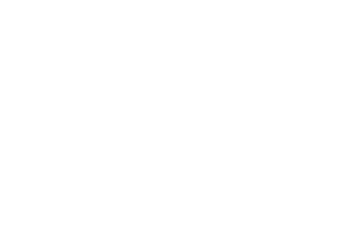

In [ ]:
from fullstream.nn import three_blob_classifier

x = three_blob_classifier()
_ = x.train(num_epochs=1)
nn_params = x.params

In [ ]:
sig, bkg1, bkg2 = get_three_blobs()

bkg_vars = jax.numpy.asarray([bkg1, bkg2])

sighist, bkghist, bkguncert = hists_from_nn_bkg_var(x.predict, nn_params, sig, bkg_vars)

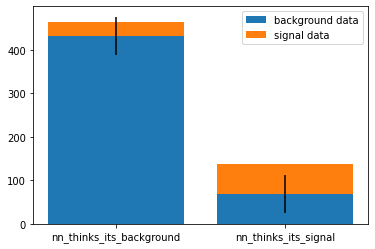

In [ ]:
plt.bar(
    ["nn_thinks_its_background", "nn_thinks_its_signal"],
    bkghist,
    label="background data",
    yerr=bkguncert,
)
plt.bar(
    ["nn_thinks_its_background", "nn_thinks_its_signal"],
    sighist,
    bottom=bkghist,
    label="signal data",
)
plt.legend()

In [ ]:
# export
def simple_nn_logpdf(nn_pars, nn, pars, data, sig_data, bkg_data, bkg_uncerts):
    """Return pyhf.Model.logpdf for a simple two-bin model, containing a signal and background histogram created using hists_from_nn. Mostly for demo purposes."""
    tensorlib, _ = pyhf.get_backend()

    sig_hist, bkg_hist = hists_from_nn(nn, nn_pars, sig_data, bkg_data)

    spec = {
        "channels": [
            {
                "name": "singlechannel",
                "samples": [
                    {
                        "name": "signal",
                        "data": sig_hist,
                        "modifiers": [
                            {"name": "mu", "type": "normfactor", "data": None}
                        ],
                    },
                    {
                        "name": "background",
                        "data": bkg_hist,
                        "modifiers": [
                            {
                                "name": "uncorr_bkguncrt",
                                "type": "shapesys",
                                "data": bkg_hist,
                            }
                        ],
                    },
                ],
            }
        ]
    }
    model = pyhf.Model(spec)

    data += model.config.auxdata
    data = tensorlib.astensor(data)
    pars = tensorlib.astensor(pars)

    # grad only defined for scalar output functions, not [scalar]
    return model.logpdf(pars, data)[0]

In [ ]:
# with jax
jax.value_and_grad(simple_nn_logpdf)(
    x.params,
    nn=x.predict,
    pars=[1.0, 1.0, 1.0],
    data=[100.0, 20.0],
    sig_data=sig,
    bkg_data=bkg1,
    bkg_uncerts=[7, 7],
)

(DeviceArray(-300.32010586, dtype=float64),
 [(DeviceArray([[-4.6235928e-04, -5.6928642e+01,  1.0801580e+00,
                  4.3102951e+01, -1.3496366e+01],
                [ 1.0061818e-02, -9.7452606e+01,  1.8475350e+00,
                  7.3784592e+01, -2.3103380e+01]], dtype=float32),
   DeviceArray([ 2.0602194e-03, -1.7377464e+01,  3.2941496e-01,
                 1.3157135e+01, -4.1197529e+00], dtype=float32)),
  (),
  (DeviceArray([[ 1.9941838e-04, -1.9941838e-04],
                [ 1.5413854e+01, -1.5413854e+01],
                [ 2.9460168e+00, -2.9460168e+00],
                [ 4.4130726e+01, -4.4130726e+01],
                [ 3.2087624e+01, -3.2087624e+01]], dtype=float32),
   DeviceArray([ 10.69018, -10.69018], dtype=float32)),
  ()])